In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
import pickle, gzip
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from scipy import ndimage

In [84]:
path_to_flatland_train_data = 'data/flatland_train.data'

In [85]:
X, y = pickle.load(gzip.open(path_to_flatland_train_data, 'rb'))
# X - data of images
# y - image labels referenced as the number of corners the shape has
# Circle has 0 corners.

In [86]:
X.shape

(10000, 50, 50)

In [87]:
y.shape

(10000,)

In [88]:
np.unique(y)

array([0., 3., 4., 5., 6.])

In [89]:
y=np.where(y>0,y-2,y)
np.unique(y)

array([0., 1., 2., 3., 4.])

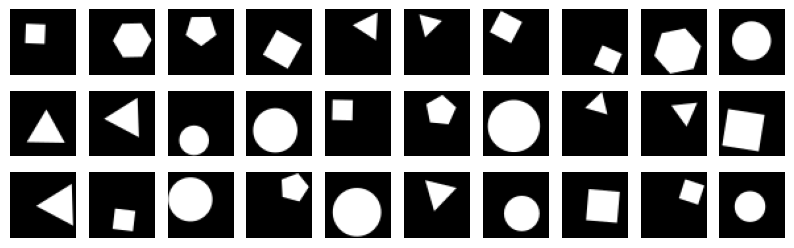

In [90]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.axis('off')
plt.show()

# Data modification
The models seem to look beyond the borders at the black background. We will attempt to fix that by highlighting the edges of the shapes.

In [91]:
def highlight_edges(image):
  #Sobel filter
  dx = ndimage.sobel(image,1)
  dy = ndimage.sobel(image,0)
  edges = np.hypot(dx,dy)
  edges = (edges - edges.min()) / (edges.max() - edges.min())
  edges[edges < 0.9] = 0
  # Can make edges thicker or thinner. (Greater value = thinner)
  # The model will potentially be more sensitive to very thin edges.

  return edges

In [92]:
X_highlight = np.array([highlight_edges(image) for image in X])

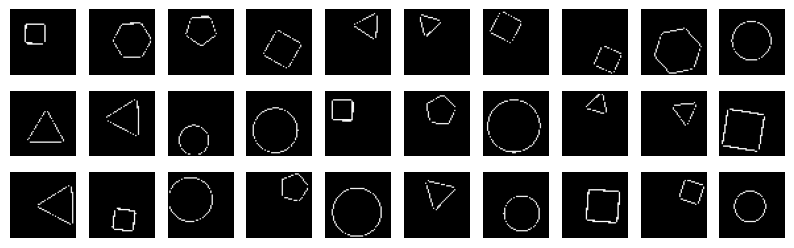

In [93]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(X_highlight[i], cmap='gray')
    plt.axis('off')
plt.show()

In [94]:
X = X_highlight

Upon trying a new model, the saliency shows the model is looking much much less at the black background. This, however changes when a batchnorm is applied.

# More artifical data
We can give the model more training data and make it easier for it to recognize shapes in different rotations.
We can increase the size of the dataset by 4 by Flipping Horizontally, Flipping Vertically, Flipping Horizontally & Vertically.

In [95]:
import torch

augmented_data = []

for image in X:
    augmented_data.append(image) 
    augmented_data.append(np.flip(image, axis=1))  # Horizontal flip
    augmented_data.append(np.flip(image, axis=0))  # Vertical flip
    augmented_data.append(np.flip(image, axis=(0,1)))  # Horizontal & vertical flip

# Stack all images to create the final augmented dataset
augmented_data = np.stack(augmented_data)  # Shape will be (40000, 50, 50)


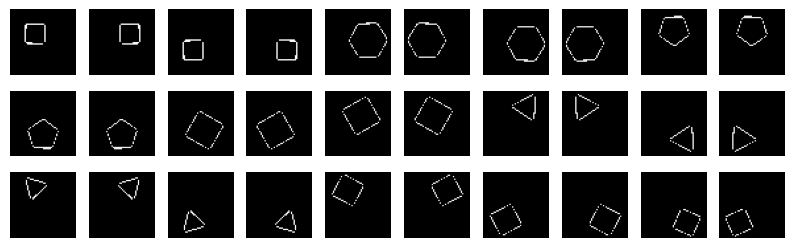

In [96]:
plt.figure(figsize=(10, 3))
for i in range(30):
    plt.subplot(3, 10, i + 1)
    plt.imshow(augmented_data[i], cmap='gray')
    plt.axis('off')
plt.show()

In [97]:
X = augmented_data
y = np.repeat(y,4)

# Model

In [98]:
training_images = torch.from_numpy(X).float()
training_labels = torch.from_numpy(y).long()

train_dataset = TensorDataset(training_images.unsqueeze(1), training_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [99]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64,128,kernel_size=3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.1)
        self.fc1 = nn.Linear(25*25*128,128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 5)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        return x

The model likes dropouts before a relu, especially big dropouts, but it starts hating dropouts when BatchNorm is introduced earlier, dropouts then must be reduced to a smaller value. If the dropout is too small, it starts to diverge. Similarly if it's too big, it diverges.

In [100]:
model = Network()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
# Increase convergance speed through scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Network(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=80000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
epochs = 50
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss/len(train_loader))
    scheduler.step()
    print(f"Epoch [{epoch + 1}/{epochs}], running_loss: {running_loss/len(train_loader)}")

Epoch [1/50], running_loss: 1.1338266296386719
Epoch [2/50], running_loss: 0.4616493126153946
Epoch [3/50], running_loss: 0.25340194696187973
Epoch [4/50], running_loss: 0.182153936997056
Epoch [5/50], running_loss: 0.144677992798388
Epoch [6/50], running_loss: 0.12233151169121266
Epoch [7/50], running_loss: 0.09782073305547237
Epoch [8/50], running_loss: 0.08654818476177752
Epoch [9/50], running_loss: 0.06767586342990399
Epoch [10/50], running_loss: 0.06487847970798612
Epoch [11/50], running_loss: 0.030733750349842014
Epoch [12/50], running_loss: 0.019912206911481916
Epoch [13/50], running_loss: 0.014390752950450406
Epoch [14/50], running_loss: 0.01210605751280673
Epoch [15/50], running_loss: 0.014448398699751125
Epoch [16/50], running_loss: 0.013640176988905297
Epoch [17/50], running_loss: 0.014647790832212194


In [125]:
model.eval()
incorrect_images = []
incorrect_labels = []
predicted_labels = []


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        incorrect_images.extend(images[incorrect_indices].cpu())
        incorrect_labels.extend(labels[incorrect_indices].cpu())
        predicted_labels.extend(predicted[incorrect_indices].cpu())

test_accuracy = 100 * (len(test_dataset) - len(incorrect_images)) / len(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Bad guesses: {len(incorrect_images)}")

Test Accuracy: 98.40%
Bad guesses: 128


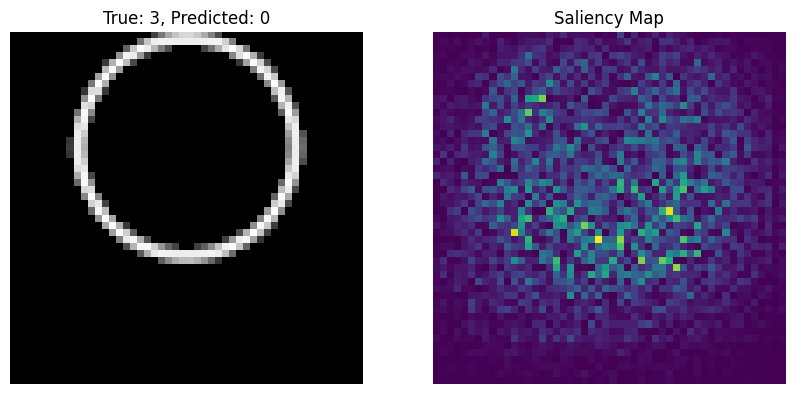

In [126]:
index = 15

image = incorrect_images[index].unsqueeze(0).to(device)
image.requires_grad_()

model.eval()
output = model(image)
_, predicted_class = torch.max(output, 1)

output[:, predicted_class].backward()
gradients = image.grad.data.abs().squeeze()
gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(incorrect_images[index].squeeze(), cmap='gray')
plt.title(f"True: {incorrect_labels[index].item()}, Predicted: {predicted_labels[index].item()}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradients.cpu())
plt.title("Saliency Map")
plt.axis('off')

plt.show()

In [127]:
#torch.save(model,'model_iter2.pth')

# Submission Prediction String
Note: Model is predicting -2 offset for shapes with corners >0.

In [128]:
X, y = pickle.load(gzip.open('data/flatland_test.data', 'rb'))
tr_x = np.array([highlight_edges(image) for image in tr_x])
tr_x = torch.from_numpy(X).float()
dataset = TensorDataset(tr_x.unsqueeze(1))
all_data = dataset.tensors[0]

all_data = all_data.to(device)

loaded_model = torch.load('saved_models/model_iter2.pth')
loaded_model.eval()
with torch.no_grad():
  all_predictions=loaded_model(all_data)
_,predicted_class = torch.max(all_predictions,1)
predicted_class = torch.where(predicted_class != 0, predicted_class+2, predicted_class)
#correct_predictions = (predicted_class == all_labels).sum().item()

predicted_class = predicted_class.cpu().numpy()



NameError: name 'tr_x' is not defined

In [67]:
print(''.join([str(round(p)) for p in predicted_class]))

4444433343444443344444344444434444444345444343444353344344444443443343444443434344534444444444344443444443444334354434434444444444444434444444444444334444444444434434434445544454444444344444444443434334443344434444343444443544643444444445444443344444344433444443443443444434444443344444454443445443444344454544344434444434444344444444444354444444344444446444443444344444444344444444443444444444434344444354434434444443454444344434445454443443344444434443444344444444444344343435444444444544445444344433344444434444454534444444334453444443334343454434443444344444444443444444444444444444334444444355454444443443444344444434443544443444344344443443443343345444443444444444444434444344334344345343333444334445553444444444443344434434444444544344443444444344433444344445444443444443444344444443434444444444454444444444334444444444444443454443434344344444444433444444444343454434434444444445344444444433444433344444444444334444444444334434344434434444443443444444434443444444344345345444434344443444344443

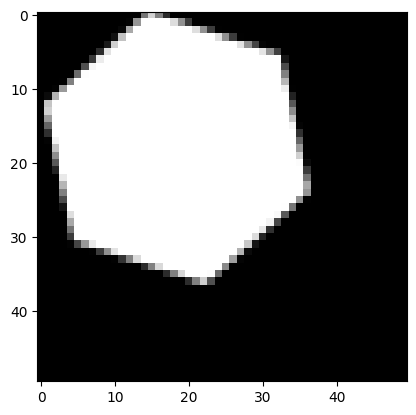

In [68]:
plt.imshow(all_data[0].squeeze(), cmap='gray')